In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/My Drive/CoconutMaturity/OrganizedDataset.zip" -d /content/CoconutMaturity
!ls /content/CoconutMaturity/OrganizedDataset

Archive:  /content/drive/My Drive/CoconutMaturity/OrganizedDataset.zip
   creating: /content/CoconutMaturity/OrganizedDataset/
  inflating: /content/CoconutMaturity/OrganizedDataset/.DS_Store  
  inflating: /content/CoconutMaturity/__MACOSX/OrganizedDataset/._.DS_Store  
   creating: /content/CoconutMaturity/OrganizedDataset/Test/
   creating: /content/CoconutMaturity/OrganizedDataset/Train/
   creating: /content/CoconutMaturity/OrganizedDataset/Validation/
  inflating: /content/CoconutMaturity/OrganizedDataset/Test/.DS_Store  
  inflating: /content/CoconutMaturity/__MACOSX/OrganizedDataset/Test/._.DS_Store  
   creating: /content/CoconutMaturity/OrganizedDataset/Test/Old/
   creating: /content/CoconutMaturity/OrganizedDataset/Test/Mature/
   creating: /content/CoconutMaturity/OrganizedDataset/Test/Young/
   creating: /content/CoconutMaturity/OrganizedDataset/Test/NonCoconut/
  inflating: /content/CoconutMaturity/OrganizedDataset/Train/.DS_Store  
  inflating: /content/CoconutMaturity/

In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transforms for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Load the datasets
train_data = datasets.ImageFolder('/content/CoconutMaturity/OrganizedDataset/Train', transform=transform)
val_data = datasets.ImageFolder('/content/CoconutMaturity/OrganizedDataset/Validation', transform=transform)
test_data = datasets.ImageFolder('/content/CoconutMaturity/OrganizedDataset/Test', transform=transform)

# Create data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Verify dataset sizes
print(f"Train dataset size: {len(train_data)}")
print(f"Validation dataset size: {len(val_data)}")
print(f"Test dataset size: {len(test_data)}")

Train dataset size: 2882
Validation dataset size: 360
Test dataset size: 362


In [4]:
import torch.nn as nn
from torchvision.models import resnet18

# Load the pretrained ResNet model
model = resnet18(pretrained=True)
# Modify the final fully connected layer to match the number of classes
model.fc = nn.Linear(model.fc.in_features, 4)  # 4 classes: Young, Mature, Old, NonCoconut

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 141MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
# Training loop
num_epochs = 10  # Adjust epochs based on your dataset size
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100.0 * correct / total
    train_loss /= len(train_loader)

    # Validation phase
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100.0 * correct / total
    val_loss /= len(val_loader)

    # Save metrics
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

# Save the model
torch.save(model.state_dict(), "/content/drive/My Drive/CoconutMaturity/resnet_coconut_model.pth")
print("Model saved!")

Epoch 1/10, Train Loss: 0.1988, Train Acc: 93.16%, Val Loss: 0.1504, Val Acc: 96.11%
Epoch 2/10, Train Loss: 0.0848, Train Acc: 97.47%, Val Loss: 0.0730, Val Acc: 97.50%
Epoch 3/10, Train Loss: 0.0711, Train Acc: 97.61%, Val Loss: 0.0737, Val Acc: 97.22%
Epoch 4/10, Train Loss: 0.1280, Train Acc: 98.75%, Val Loss: 0.0663, Val Acc: 98.61%
Epoch 5/10, Train Loss: 0.1681, Train Acc: 95.39%, Val Loss: 0.1050, Val Acc: 95.83%
Epoch 6/10, Train Loss: 0.1740, Train Acc: 96.81%, Val Loss: 0.1610, Val Acc: 93.61%
Epoch 7/10, Train Loss: 0.2287, Train Acc: 93.51%, Val Loss: 0.1784, Val Acc: 95.00%
Epoch 8/10, Train Loss: 0.1339, Train Acc: 96.32%, Val Loss: 0.0499, Val Acc: 98.89%
Epoch 9/10, Train Loss: 0.1110, Train Acc: 97.12%, Val Loss: 0.0416, Val Acc: 98.06%
Epoch 10/10, Train Loss: 0.0743, Train Acc: 97.78%, Val Loss: 0.0270, Val Acc: 99.17%
Model saved!


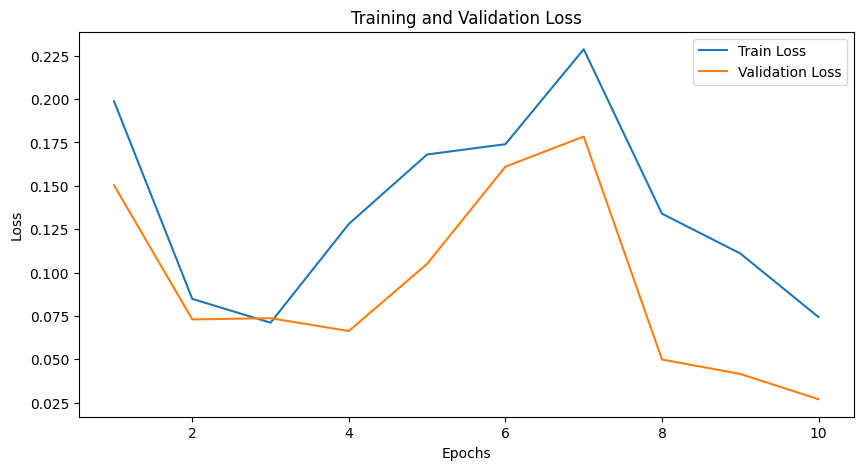

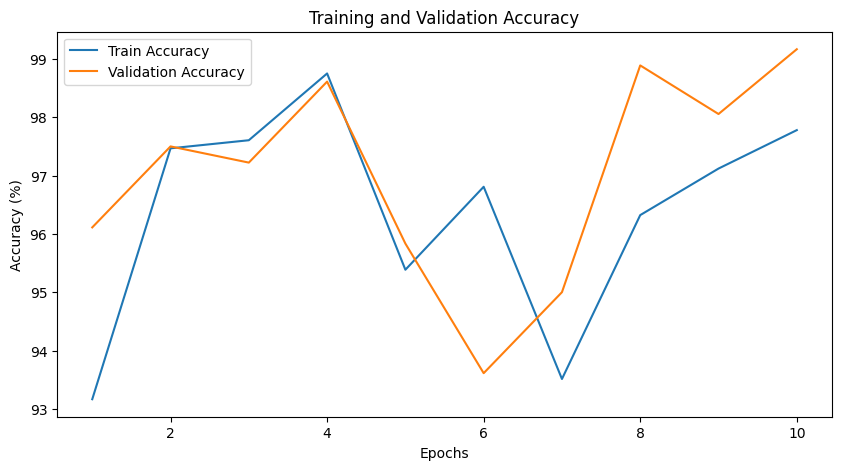

In [6]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_loss_list, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_acc_list, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_acc_list, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [7]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 98.62%


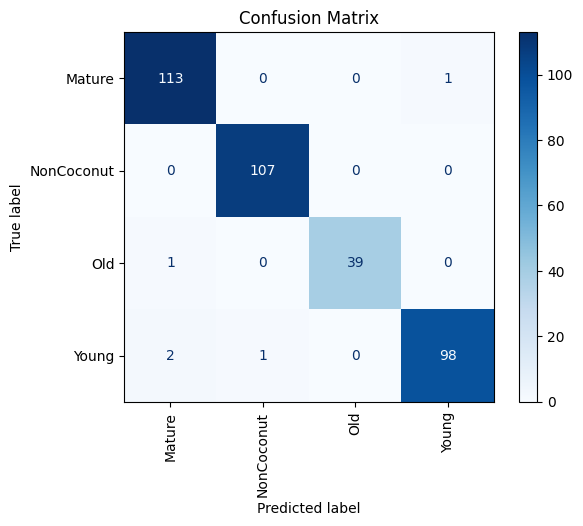

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Set the model to evaluation mode
model.eval()

# Initialize variables
all_preds = []
all_labels = []

# Loop through test data
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=np.arange(len(train_data.classes)))

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_data.classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.title("Confusion Matrix")
plt.show()

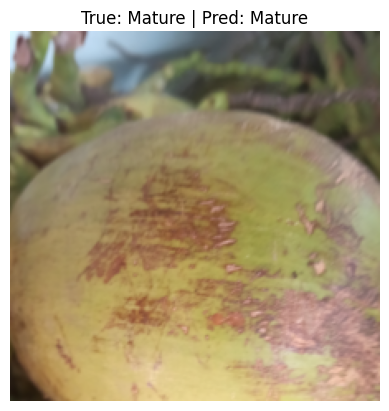

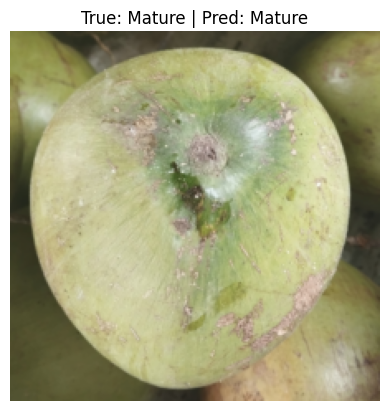

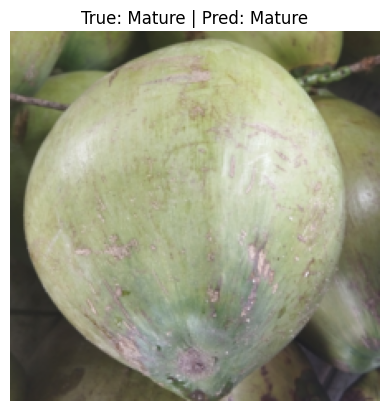

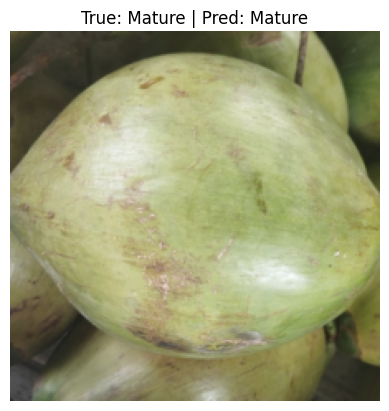

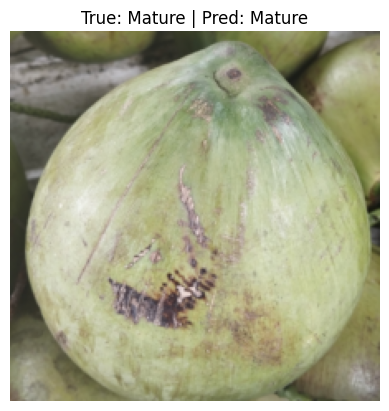

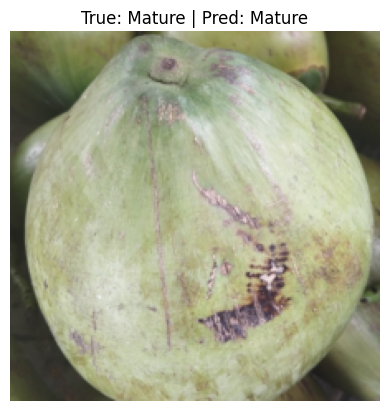

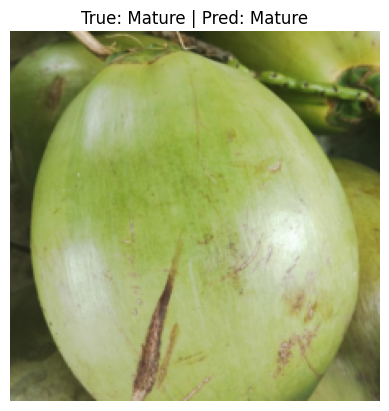

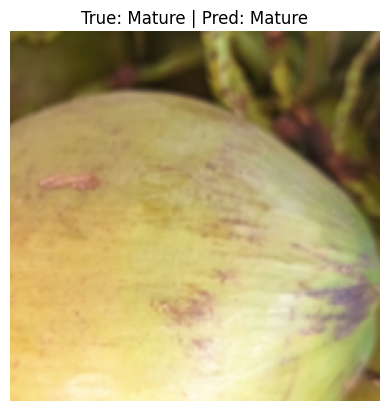

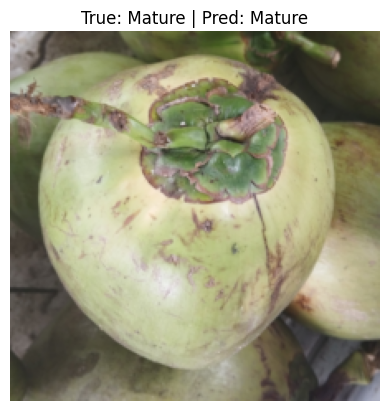

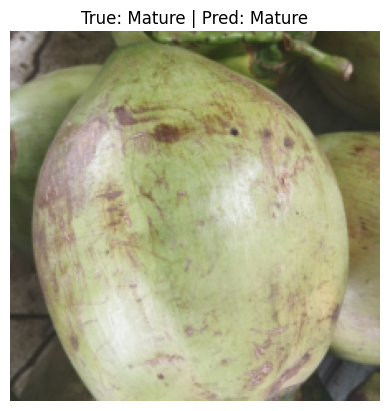

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Get class labels
class_labels = train_data.classes  # Replace 'train_data' if your variable name differs

# Iterate over the test dataset
for i, (inputs, labels) in enumerate(test_loader):
    inputs, labels = inputs.to(device), labels.to(device)

    # Predict the class
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    # Convert inputs to CPU and NumPy for visualization
    inputs = inputs.cpu().numpy().transpose((0, 2, 3, 1))
    inputs = inputs * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
    inputs = np.clip(inputs, 0, 1)  # Clip values for proper image visualization

    for j in range(min(len(inputs), 10)):  # Show up to 10 images
        plt.imshow(inputs[j])
        plt.title(f"True: {class_labels[labels[j]]} | Pred: {class_labels[preds[j]]}")
        plt.axis('off')
        plt.show()
    break  # Show only the first batch